# implicit

- implicit은 암시적인 데이터에 적합
- 유저가 봤는지 안봤는지에 초점을 두려고 함
- 1점이상이면 1, 0점이면 0으로 둠

In [1]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 34.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares as ALS
import implicit
import random

/usr/local/lib/python3.8/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


### 데이터 불러오기

In [4]:
df=pd.read_csv('/content/drive/MyDrive/ml-100k/movie_lens.csv', index_col=0)
df_c = df.astype(dtype='int32',errors='ignore')
df_c.iloc[:,5:7]=df_c.iloc[:,5:7].astype('category')
df_c.iloc[:,-1:]=df_c.iloc[:,-1:].astype('category')

- 데이터 삭제

In [5]:
unknown = df_c['movie_title'] !='unknown'
df_c = df_c[unknown]

In [6]:
train, test = train_test_split(df_c[['user_id','movie_id','rating']],test_size=0.2,
                               shuffle=True, random_state=3)

In [11]:
train_matrix_p = train.pivot_table('rating', index='user_id', columns='movie_id').fillna(0)
test_matrix_p = test.pivot_table('rating', index='user_id', columns='movie_id').fillna(0)

train_matrix=csr_matrix(train_matrix_p.values)
test_matrix=csr_matrix(test_matrix_p.values)

### 훈련 데이터 만들기
  - 훈련 데이터는 랜덤하게 일정한 확률로유저/아이템 상호작용 몇 개를 가려 고객이 그 아이템을 구매한 적이 없는 것처럼 만듭니다 (= 몇 개의 구매 수량을 0으로 채워넣습니다). 
  - 테스트 데이터는 원본 데이터에서 구매한 이력이 있으면 1, 없으면 0으로 채운 행렬입니다. 
  - 이런 방식으로 데이터를 세팅하면, 테스트 데이터에서 얼마나 유저가 실제 구매한 아이템이 추천됐는지 파악할 수 있습니다. 만약 유저가 추천된 아이템을 실제 구매한 경우가 많을 경우 추천 시스템이 제대로 작동한다 말할 수 있겠죠.

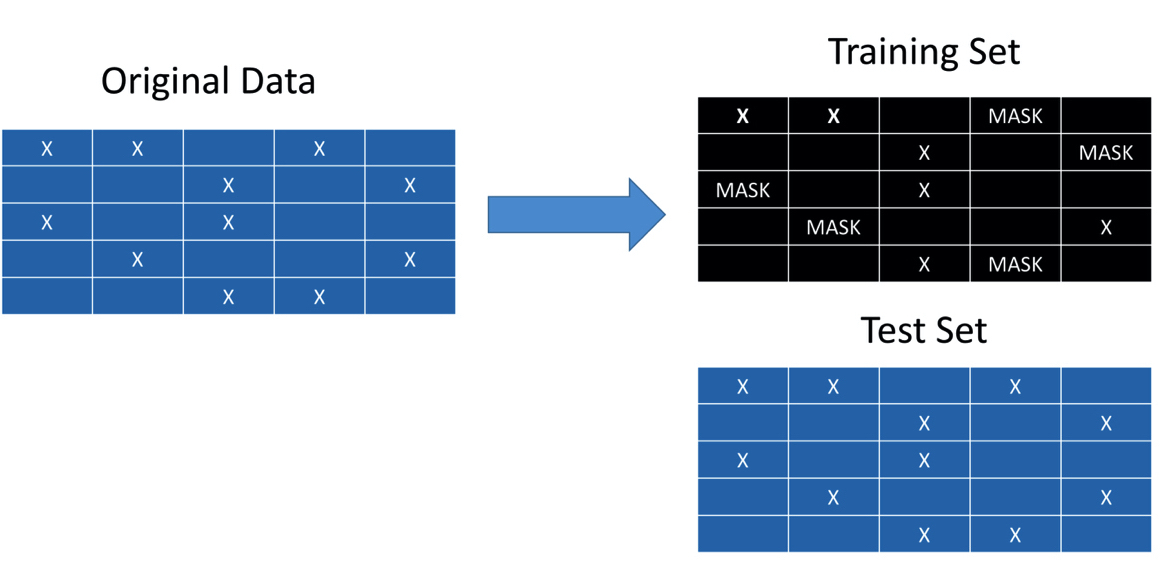

In [12]:
def make_train (matrix, percentage = .2):
    '''
    -----------------------------------------------------
    설명
    유저-아이템 행렬 (matrix)에서 
    1. 0 이상의 값을 가지면 1의 값을 갖도록 binary하게 테스트 데이터를 만들고
    2. 훈련 데이터는 원본 행렬에서 percentage 비율만큼 0으로 바뀜
    
    -----------------------------------------------------
    반환
    training_set: 훈련 데이터에서 percentage 비율만큼 0으로 바뀐 행렬
    test_set:     원본 유저-아이템 행렬의 복사본
    user_inds:    훈련 데이터에서 0으로 바뀐 유저의 index
    '''
    test_set = matrix.copy()
    test_set[test_set !=0] = 1 # binary하게 만들기
    
    training_set = matrix.copy()
    nonzero_inds = training_set.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    
    random.seed(0)
    num_samples = int(np.ceil(percentage * len(nonzero_pairs)))
    samples = random.sample (nonzero_pairs, num_samples)
    
    user_inds = [index[0] for index in samples]
    item_inds = [index[1] for index in samples]
    
    training_set[user_inds, item_inds] = 0
    training_set.eliminate_zeros()
    
    return training_set, test_set, list(set(user_inds))

# 훈련, 테스트 데이터 생성
product_train, product_test, product_users_altered = make_train(train_matrix, 0.2)

In [17]:
ALS = implicit.als.AlternatingLeastSquares(
    factors=200, regularization=40,
    iterations=100, random_state=42
)

In [18]:
#신뢰행렬 alpha
alpha=40

In [19]:
ALS.fit((product_train*alpha).astype('double'))

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
user_vecs = ALS.user_factors
item_vecs = ALS.item_factors

In [21]:
user_vecs[0].shape

(200,)

In [22]:
predictions = [csr_matrix(user_vecs),csr_matrix(item_vecs.T)]

In [35]:
n_similar= 25
user_id = 50
similar_items = ALS.similar_items(user_id,n_similar)

In [36]:
similar_items

(array([  50,  697,   42,  935,  718,  400,  568, 1086,  621,   76,  939,
        1211, 1088,  560,  730,  547,  737,  759,   65, 1154,  721,  364,
         240,  938,  947], dtype=int32),
 array([1.        , 0.38446984, 0.3698668 , 0.34087545, 0.33351216,
        0.33311972, 0.33014095, 0.32968467, 0.31722215, 0.31714755,
        0.31429416, 0.31390694, 0.31160796, 0.3094656 , 0.30645514,
        0.3062099 , 0.30263036, 0.2996396 , 0.29792723, 0.29286602,
        0.29203203, 0.28862447, 0.28184587, 0.2803748 , 0.27816805],
       dtype=float32))

In [37]:
similar_users = ALS.similar_users(user_id,n_similar)
similar_users

(array([ 50, 527, 410, 830, 236, 113, 631, 866, 321, 699, 747, 351, 690,
        182, 114, 640,  76, 420, 775,  41, 325, 896, 214, 123, 574],
       dtype=int32),
 array([1.        , 0.37437162, 0.3623691 , 0.33993867, 0.3313491 ,
        0.30783242, 0.307196  , 0.30698937, 0.3021449 , 0.29240105,
        0.29128125, 0.28719154, 0.28590462, 0.28304356, 0.2672836 ,
        0.2649793 , 0.26148582, 0.25997263, 0.2552198 , 0.2543921 ,
        0.2510103 , 0.24957223, 0.24917603, 0.24885419, 0.24632414],
       dtype=float32))

### 추천 시스템 평가하기
  - 유저마다 예측 평점이 높은 아이템이 실제로 본 영화인지 확인
  - ROC커브 밑에 차지하는 면적(AUC)이 넓을수록 추천할 아이템과 실제로 구매한 아이템이 비슷함
  [als](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe)

In [23]:
from sklearn import metrics

def auc_score (test, predictions):
    '''
    fpr, tpr를 이용해서 AUC를 계산하는 함수
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr,tpr)

In [24]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    가려진 정보가 있는 유저마다 AUC 평균을 구하는 함수
    ----------------------------------------
    input
    1. training_set: make_train 함수에서 만들어진 훈련 데이터 (일정 비율로 아이템 구매량이 0으로 가려진 데이터)
    2. prediction: implicit MF에서 나온 유저/아이템 별로 나온 예측 평점 행렬
    3. altered_users: make_train 함수에서 아이템 구매량이 0으로 가려진 유저
    4. test_set: make_train함수에서 만든 테스트 데이터
    ----------------------------------------
    반환
    추천 시스템 유저의 평균 auc
    인기아이템 기반 유저 평균 auc
    '''
    # 리스트 초기화
    store_auc = []
    popularity_auc = []
    
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # 모든 유저의 아이템별 구매횟수 합
    item_vecs = predictions[1] # 아이템 latent 벡터
    
    for user in altered_users:
        training_row = training_set[user,:].toarray().reshape(-1) # 유저의 훈련데이터
        zero_inds = np.where(training_row == 0) # 가려진 아이템 Index
        
        # 가려진 아이템에 대한 예측
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # 가려진 아이템에 대한 실제값
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        
        # 가려진 아이템에 대한 popularity (구매횟수 합)
        pop = pop_items[zero_inds]
        
        # AUC 계산 
        store_auc.append(auc_score(actual, pred))
        popularity_auc.append(auc_score(actual,pop))
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  

In [25]:
calc_mean_auc(product_train,product_users_altered,predictions,product_test)

(0.909, 0.853)

- 결과를 확인해보니 추천시스템이 가장 인기있는 아이템 기반 알고리즘보다 더 나은 성능을 낸다.

### als 추천하기

In [41]:
matrix = df_c.pivot_table('rating', index='user_id', columns='movie_id').fillna(0)
matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 추천<br>

[참고](https://assaeunji.github.io/machine%20learning/2020-11-29-implicitfeedback/)

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [47]:

def recommend(user_id,mf_train,user_vecs,item_vecs,num_items=25):
  # 유저위치
  user_ind = np.where(matrix.index==user_id)[0][0]
  pref_vec = mf_train[user_ind,:].toarray()                   # 훈련 데이터의 실제 평점
  pref_vec = pref_vec.reshape(-1)+1                           # 1을 더해 안본것들을 1로 만들고
  pref_vec[pref_vec > 1] = 0                                  # 본 것들을 모두 0으로 만듦으로써 곱해질때 본 것들이 안나오게!
  rec_vector = user_vecs[user_ind,:].dot(item_vecs.T)         # 추천 시스템에 기반한 예측 평점


  # Min-Max Scaling
  min_max = MinMaxScaler()
  rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
  recommend_vector = pref_vec*rec_vector_scaled  # 구매하지 않은 아이템에 대해서만 예측 평점이 남도록

  product_idx = np.argsort(recommend_vector)[::-1][:num_items+1] # num_items만큼 내림차순으로 평점 정렬한 index
    

  movie_list=df_c[['movie_id','movie_title']].drop_duplicates()

  recommend = movie_list[movie_list['movie_id'].isin(product_idx+1)].reset_index(drop=True)

  return recommend


In [48]:
recommend(12,product_train,user_vecs,item_vecs)

,movie_id,movie_title
0,70,Four Weddings and a Funeral (1994)
1,153,"Fish Called Wanda, A (1988)"
2,173,"Princess Bride, The (1987)"
3,71,"Lion King, The (1994)"
4,117,"Rock, The (1996)"
5,100,Fargo (1996)
6,98,"Silence of the Lambs, The (1991)"
7,356,"Client, The (1994)"
8,77,"Firm, The (1993)"
9,195,"Terminator, The (1984)"


#### 성능평가(precision/recall@k) 

##### 유저가 본 영화(top25)

In [ ]:
# e 안나오게 하는 법
import sys

import numpy as np

np.set_printoptions(threshold=sys.maxsize)

In [54]:
def top_get_movie(user_id,matrix_p,item=25):
  movie_list=df_c[['movie_id','movie_title']].drop_duplicates()

  trans = matrix_p[matrix_p.index==user_id].T
  trans.columns=['rating']

  movie_ind=trans.sort_values(['rating']).tail(item).index.tolist()  
  user_movie = movie_list[movie_list['movie_id'].isin(movie_ind)]
  
  return user_movie
  

In [ ]:
top_get_movie(12,train_matrix_p)

##### 유저에게 추천(본 것들도 포함)

In [49]:
def recommend(user_id,mf_train,user_vecs,item_vecs,num_items=25):
  # 유저위치
  rec_vector = user_vecs[user_id-1,:].dot(item_vecs.T)         # 추천 시스템에 기반한 예측 평점


  # Min-Max Scaling
  min_max = MinMaxScaler()
  rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 

  product_idx = np.argsort(rec_vector_scaled)[::-1][:num_items+1] # num_items만큼 내림차순으로 평점 정렬한 index
    

  movie_list=df_c[['movie_id','movie_title']].drop_duplicates()

  recommend = movie_list[movie_list['movie_id'].isin(product_idx+1)].reset_index(drop=True)

  return recommend

In [ ]:
recommend(196,product_train,user_vecs,item_vecs,num_items=25)

In [57]:
def precision_recall(user_id,data):
  count=0
  user_seen = top_get_movie(user_id,train_matrix_p)['movie_title'] #유저가 본 영화
  user_recommend = recommend(user_id,data,user_vecs,item_vecs)['movie_title'] #유저가 추천받은 영화
  for i in user_seen:
    for j in user_recommend:
      if i==j:
        count+=1
  
  precision = count/len(user_recommend)
  recall = count/len(user_seen)
  
  return precision, recall

In [58]:
precision_recall(12,train_matrix)

(0.5384615384615384, 0.56)

In [59]:
precision_recall(30,train_matrix)

(0.46153846153846156, 0.48)

In [60]:
precision_recall(922,train_matrix)

(0.5, 0.52)

In [61]:
precision_recall(196,train_matrix)

(0.38461538461538464, 0.4)

#### mean_precision@k

In [62]:
def mean_precision_k(k,data):
  precision=0
  total =0
  for i in range(1,k+1):
    #train,test셋으로 분리했기 때문에 없는 user_id는 넘김
    try:
      total+=1
      precision+=precision_recall(i,data)[0]
    except:
      pass
  mean_precision = precision/total
  return mean_precision

In [63]:
mean_precision_k(400,train_matrix)

0.28152692307692306

### mean recall@k

In [64]:
def mean_recall_k(k,data):
  recall=0
  total =0
  for i in range(1,k+1):
    try:
      total+=1
      recall+=precision_recall(i,data)[1]
    except:
      pass
  mean_recall = recall/total
  return mean_recall

In [65]:
mean_recall_k(400,train_matrix)

0.2907999999999995